In [9]:
%pylab inline
import cv2
import imutils
from imutils import contours
import matplotlib.patches as patches
import pytesseract
import zbar
import labelreader
import copy

Populating the interactive namespace from numpy and matplotlib


/home/redhog/Projects/innovationgarage/price-tag-reader/env/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['outer', 'gray', 'inner']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def hierarchy2dicts(hier):
    children = {}
    parents = {}
    for self, (next, prev, firstchild, parent) in enumerate(hier[0]):
        if parent not in children: children[parent] = []
        children[parent].append(self)
        parents[self] = parent
    return children, parents

def convexity(cnt):
    """How convex is a contour, as a fraction between
    0. (convex hull infinitely larger than contour) and 1. (entirely convex)"""
    cnta = cv2.contourArea(cnt)
    if cnta == 0: return 0
    hull = cv2.convexHull(cnt)
    hulla = cv2.contourArea(hull)
    return cnta / hulla

def borderSides(idx, parents, children):
    if parents[idx] != -1:
        return parents[idx], idx
    elif children[idx]:
        return idx, children[idx][0]
    else:
        return idx, idx

def imageBorders(grad):
    grad = cv2.threshold(grad, 40, 255, cv2.THRESH_BINARY)[1]
    img_, cnts, hier = cv2.findContours(grad.copy(), cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    children, parents = hierarchy2dicts(hier)
    large = [idx for idx, cnt in enumerate(cnts)
             if cv2.contourArea(cnt) > grad.shape[0]*grad.shape[1] / 20]
    large_children = {p: [c for c in cs if c in large]
                      for p, cs in children.iteritems()}
    borders = [borderSides(idx, parents, large_children) for idx in large
               if convexity(cnts[idx]) > 0.85]
    rims = [(cv2.convexHull(cnts[outer]), cv2.convexHull(cnts[inner]))
            for outer, inner in borders]
    outerRims = [outer for outer, inner in rims]
    innerRims = [inner for outer, inner in rims]
    
    mask = np.zeros(grad.shape, dtype="uint8")
    for outerRim, innerRim in rims:
        cv2.fillPoly(mask, [outerRim, innerRim], 255)
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3)))
    return mask, rims

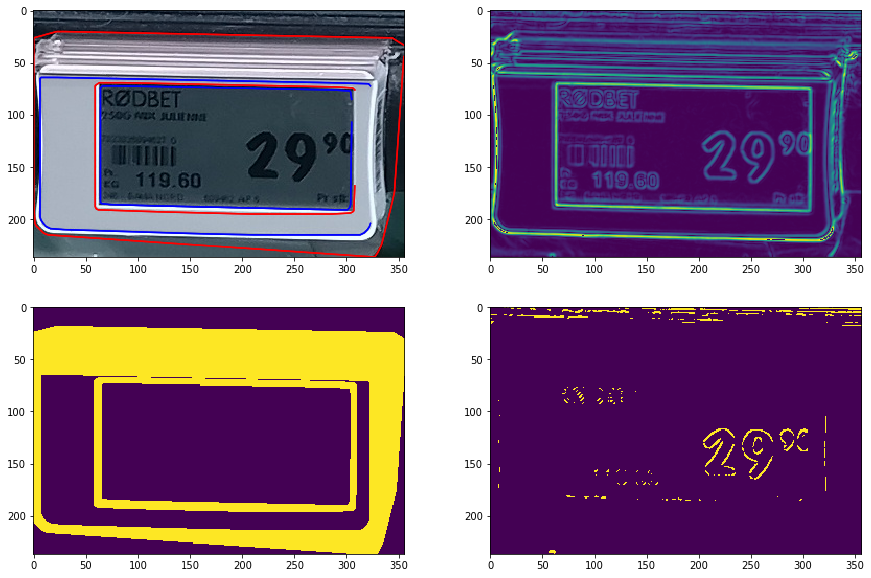

In [37]:
img = cv2.imread("haar_classifier/new_supermarket_photos/spar_results/ok/43.jpg")
#img = cv2.imread("haar_classifier/new_supermarket_photos/coop_results/10.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
grad = labelreader.imageGrads(gray)

mask, rims = imageBorders(grad)

outerRims = [outer for outer, inner in rims]
innerRims = [inner for outer, inner in rims]

objgrad = labelreader.imageObjgrad(grad, mask)

fig = plt.figure(); fig, axs = plt.subplots(2,2, figsize=(15,10)); axs = axs.flatten()
axs[0].imshow(img)

axs[1].imshow(grad)
labelreader.drawCountours(axs[0], outerRims, color="red")
labelreader.drawCountours(axs[0], innerRims, color="blue")

axs[2].imshow(mask)
axs[3].imshow(objgrad)
fig.show()


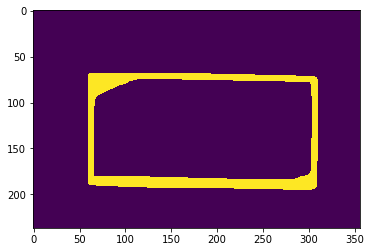

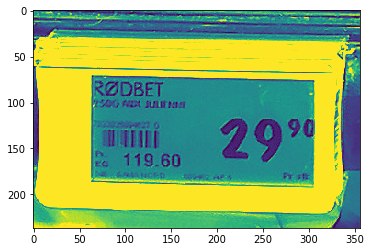

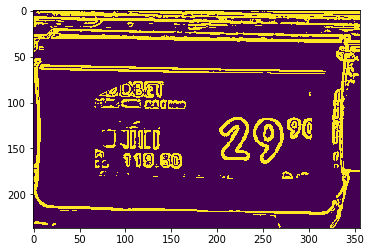

In [75]:
p = gray[mask == 0]
s = p.std()
m = np.median(p)

boosted = (((gray - (m - s)) / (2 * s)).clip(0., 1.) * 255).astype("uint8")

grad = labelreader.imageGrads(boosted)
borders, borderCnts = labelreader.imageBorders(grad)
objgrad = labelreader.imageObjgrad(grad, borders)

plt.imshow(borders)
plt.show()

plt.imshow(boosted)
plt.show()

plt.imshow(objgrad)
plt.show()

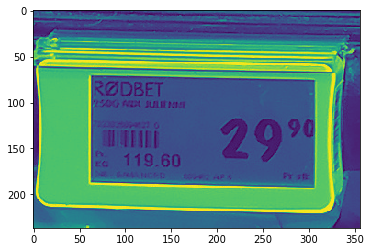

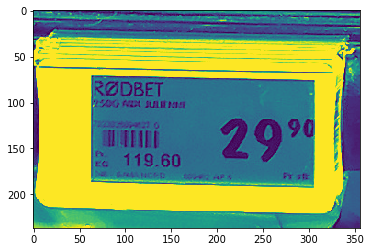

In [77]:
p = gray
s = p.std()
m = np.median(p)

boosted = (((gray - (m - s)) / (2 * s)).clip(0., 1.) * 255).astype("uint8")

plt.imshow(gray)
plt.show()

plt.imshow(boosted)
plt.show()


dtype('uint8')